## SZÉKELYDATA Erdők 
### Globális adat-betöltő és formázó munkafüzet

In [50]:
import numpy as np, requests, zipfile, StringIO, pandas as pd, json, copy

#suppres warnings
import warnings
warnings.simplefilter(action = "ignore")

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

FAO adatok betöltése - impex dollár-értékek és volumenek

In [8]:
#z = zipfile.ZipFile('Forestry_Trade_Flows_E_All_Data.zip')   #stream web content of zip file to read
z = zipfile.ZipFile('../db/Forestry_Trade_Flows_E_All_Data2.zip')   #stream web content of zip file to read
df=pd.read_csv(z.open('Forestry_Trade_Flows_E_All_Data.csv'))

In [9]:
set(df[df['Reporter Countries']=='Romania']['Element'])

{'Export Quantity', 'Export Value', 'Import Quantity', 'Import Value'}

Formázás D3plus formátumba

In [10]:
data={}
cs=set()
for i in df.T.iteritems():
    country=i[1][0]
    partner=i[1][2]
    cs.add(country)
    cs.add(partner)
    item=i[1][5]
    element=i[1][7]
    for k in range(9,44,2):
        if country not in data: data[country]=[]
        if not np.isnan(i[1][k]):
            if 'Value' in element: 
                year=int(df.columns[k][1:])
                if 'Import' in element: g="f"
                else: g="m"
                data[country].append({"partner":partner,
                                  "item":item,
                                  "g":g,
                                  "year":year,
                                  "s":i[1][k]})     

In [11]:
data={}
cs=set()
for i in df.T.iteritems():
    country=i[1][0]
    partner=i[1][2]
    cs.add(country)
    cs.add(partner)
    item=i[1][5]
    element=i[1][7]
    for k in range(9,44,2):
        if country not in data: data[country]={}
        if not np.isnan(i[1][k]):
            year=int(df.columns[k][1:])
            if 'Import' in element: g="f"
            else: g="m"
            if g not in data[country]:data[country][g]={}
            if partner not in data[country][g]:data[country][g][partner]={}
            if year not in data[country][g][partner]:data[country][g][partner][year]={}
            if item not in data[country][g][partner][year]:data[country][g][partner][year][item]={}
            if 'Value' in element: 
                data[country][g][partner][year][item]["s"]=i[1][k]
            else: 
                data[country][g][partner][year][item]["p"]=i[1][k]

In [12]:
data2={}
for country in data:
    if country not in data2:data2[country]=[]
    for g in data[country]:
        for partner in data[country][g]:
            for year in data[country][g][partner]:
                for item in data[country][g][partner][year]:
                    if (("s" in data[country][g][partner][year][item]) and ("p" in data[country][g][partner][year][item])):
                        data2[country].append({"partner":partner,
                                  "item":item,
                                  "g":g,
                                  "year":year,
                                  "s":data[country][g][partner][year][item]["s"],
                                  "p":data[country][g][partner][year][item]["p"]
                             })    

Árgrafikon

In [234]:
from jupyterthemes import jtplot

# you can select an alternative theme's plot style by name
# oceans16 | grade3 | chesterish | onedork | monokai | solarizedl
jtplot.style('solarized-light')

In [235]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.nanmedian(data))
    mdev = np.nanmedian(d)
    s = d/mdev if mdev else 0.
    return data[s<m][data[s<m]>0]

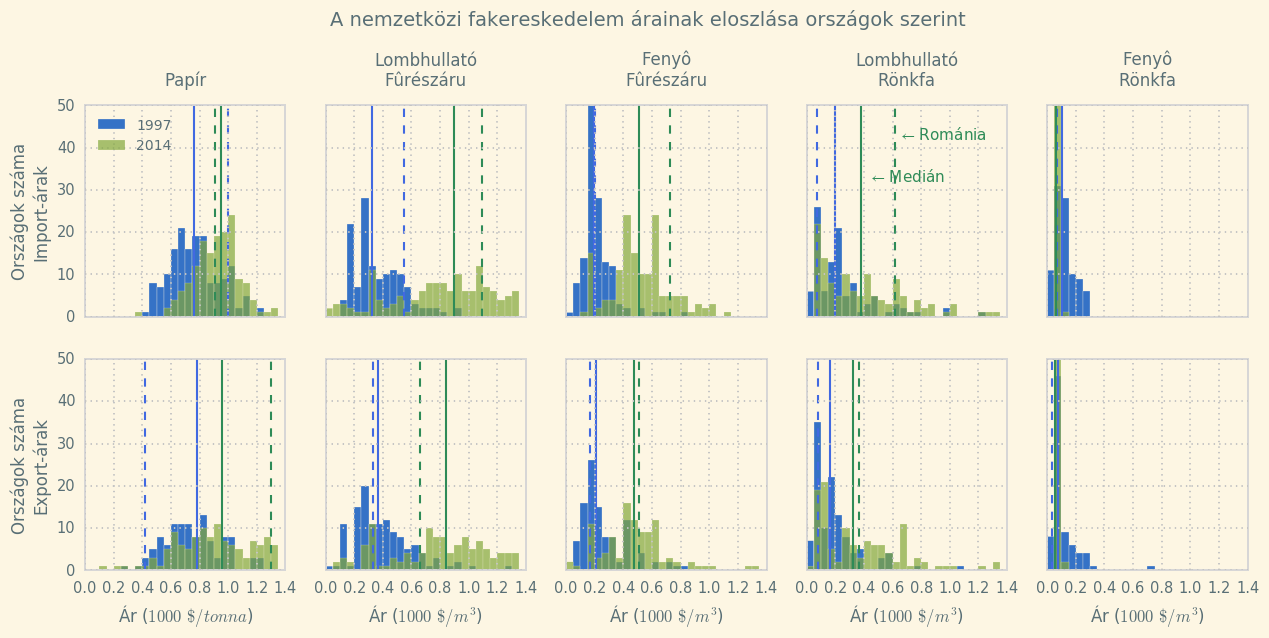

In [243]:
fig,ax=plt.subplots(2,5,figsize=(15,6))
eip=['ip','ep']
alph=[1,0.7]
yrs=['Y1997','Y2014']
colors=['royalBlue','seaGreen']
woods=[[u'Newsprint',u'Paper+-Board Ex Newsprnt'],
       [u'Sawnwood (NC)'],[u'Sawnwood (C)'],
       [u'Ind Rwd Wir (NC) Other',u'Ind Rwd Wir (NC) Tropica'],[u'Ind Rwd Wir (C)']]
ti=[u'Papír',u'Lombhullató\nFûrészáru',u'Fenyô\nFûrészáru',u'Lombhullató\nRönkfa',u'Fenyô\nRönkfa']
uni=['$\$/tonna$','$\$/m^3$','$\$/m^3$','$\$/m^3$','$\$/m^3$']
impex=['Import','Export']
for wod in range(len(woods)):
    wood=woods[wod]
    for yr in range(len(yrs)):
        year=yrs[yr]
        dx=df.set_index(['Element','Item','Reporter Countries','Partner Countries'])\
        .drop(['Reporter Country Code','Partner Country Code','Item Code',
               'Element Code','Unit'],axis=1)[year].unstack(0)
        dx['ep']=dx['Export Value']/dx['Export Quantity']
        dx['ip']=dx['Import Value']/dx['Import Quantity']
        dw=dx.loc[wood]
        for ii in range(2):
            dw=dx.loc[wood]
            dw=dw.set_index(dw.index.swaplevel(0,1))[eip[ii]]
            y=[]
            for i in dw.index.levels[0]:
                y.append(np.nanmedian(reject_outliers(np.array(dw.loc[i].values))))
            z=np.array(y)[~pd.isnull(y)]
            ax[ii][wod].hist(z,np.arange(0,1.4,0.05),alpha=alph[yr],label=year[1:])
            ax[ii][wod].set_xlim(0,1.4)
            ax[ii][wod].set_ylim(0,50)
            w=np.nanmedian(reject_outliers(np.array(dw.loc['Romania'].values)))
            ax[ii][wod].axvline(w,c=colors[yr],ls='--')
            w=np.nanmedian(y)
            ax[ii][wod].axvline(w,c=colors[yr],ls='-')
            if ii!=1:
                ax[ii][wod].set_xticklabels([])
                ax[ii][wod].set_title(ti[wod],y=1.06)
            else:
                ax[ii][wod].set_xlabel(u'Ár ('+'$1000$ '+uni[wod]+')')
            if wod!=0:
                ax[ii][wod].set_yticklabels([])
            else:
                ax[ii][wod].set_ylabel(u'Országok száma\n'+impex[ii]+u'-árak')
            if wod==2 and ii==1:
                if yr==1:
                    ax[0][3].text(0.65,42,u'$←$'+u' Románia',color=colors[yr])
                    ax[0][3].text(0.44,32,u'$←$'+u' Medián',color=colors[yr])
                ax[0][0].legend(loc=0,framealpha=0,fontsize=10)
plt.suptitle(u'A nemzetközi fakereskedelem árainak eloszlása országok szerint',y=1.06,fontsize=14)
plt.show()

Országonkénti mentés zip file-okba, amelyekbe json-okat csomagolunk

In [237]:
try:
    import zlib
    compression = zipfile.ZIP_DEFLATED
except:
    compression = zipfile.ZIP_STORED

In [ ]:
for c in data2:
    file('dummy.json','w').write(json.dumps(data2[c])) 
    zf = zipfile.ZipFile('zips2/'+str(c)+'.zip', mode='w')
    zf.write('dummy.json','data.json',compress_type=compression)
    zf.close()

Globális névjegyzékek és könyvtárak elkészítése

In [ ]:
file('json/countries2.json','w').write(json.dumps(data.keys())) 

In [ ]:
file('json/data2.json','w').write(json.dumps(data)) 

In [ ]:
cdict={}
for i in df.T.iteritems():
    if i[1][0] not in cdict:cdict[i[1][0]]=i[1][1]
    if i[1][2] not in cdict:cdict[i[1][2]]=i[1][3]
    if i[1][1] not in cdict:cdict[i[1][1]]=i[1][0]
    if i[1][3] not in cdict:cdict[i[1][3]]=i[1][2]

In [ ]:
cdict[107]=u"C\xf4te d'Ivoire"
cdict[u"C\xf4te d'Ivoire"]=cdict["C\xf4te d'Ivoire"]
cdict.pop("C\xf4te d'Ivoire")

In [ ]:
cdict[182]=u'R\xe9union'
cdict[u'R\xe9union']=cdict['R\xe9union']
cdict.pop('R\xe9union')

In [ ]:
file('json/cdict2.json','w').write(json.dumps(cdict)) 

In [ ]:
countries=[]
for k in cdict:
    try: int(k)
    except: countries.append(k)
file('json/countries2.json','w').write(json.dumps(countries)) 